# Unit Testing Optimisation

## Importing the Packages

In [60]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.use("pgf")
%matplotlib inline
plt.plot([1, 2, 3])
mpl.use("pgf")
mpl.rcParams.update(
    {
        "pgf.texsystem": "lualatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.preamble": "\n".join(
            [
                r"\usepackage{bm}",
                r"\usepackage{mathtools}",
                r"\usepackage{amsmath}",
                r"\DeclarePairedDelimiter\abs{\lvert}{\rvert}%",
                r"\DeclarePairedDelimiter\norm{\lVert}{\rVert}",
                r"\makeatletter",
                r"\let\oldabs\abs",
                r"\def\abs{\@ifstar{\oldabs}{\oldabs*}}",
                r"\let\oldnorm\norm",
                r"\def\norm{\@ifstar{\oldnorm}{\oldnorm*}}",
                r"\makeatother",
                r"\usepackage[dvipsnames]{xcolor}", 
                r"\definecolor{myred}{RGB}{205, 108, 46}",
            ]
        ),
        "font.serif": ["Computer Modern Roman"],
    }
)

import matplotlib.font_manager
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size, make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import matplotlib.cm as cm

import numpy as np
import scipy as sc
import scipy.io as io
from scipy.stats import multivariate_normal
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax, value_and_grad, tree_multimap, tree_map

In [61]:
from jax.config import config
config.update("jax_enable_x64", True)

## Defining SE Covariance

In [62]:
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

In [63]:
Vec_SE = jit(vmap(vmap(Squared_exp, in_axes=[None,0,None,None]),in_axes=[0,None,None,None]))

## Creating Test Data

In [64]:
key = random.PRNGKey(1)
key, *subkeys = random.split(key, 4)

In [65]:
# Time resolution
time_bin = 0.005

### Input Spike Train

In [66]:
subkeyx = subkeys[-1]

# Time horizon for input data
x_maxt = 2.5

# Maximum index of input data
k = np.floor(x_maxt/time_bin).astype(np.int64)

xtime = np.linspace(0.0, x_maxt, k + 1)

xtest = random.bernoulli(subkeyx, 0.1, (k+1,)).astype(np.float64)

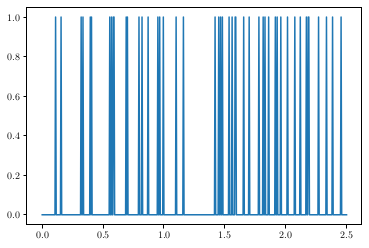

In [99]:
plt.plot(xtime, xtest)

### True Filter

In [67]:
subkeyf = subkeys[-2]

# Filter horizon
f_maxt = 0.25

# Maximum index of filter data
n = np.floor(f_maxt/time_bin).astype(np.int64)
ftime = np.linspace(0.0, f_maxt, n + 1)

# True filter mean
mu_true = np.zeros(n + 1)
# True filter variance
sig_true = 1.0
# True filter length scale
ell_true = 0.02

cov_true = Vec_SE(ftime, ftime, sig_true, ell_true)
chol_true = np.linalg.cholesky(cov_true + 1e-6 * np.eye(n + 1))

ftrue = mu_true + chol_true @ random.normal(subkeyf, (n + 1, ))

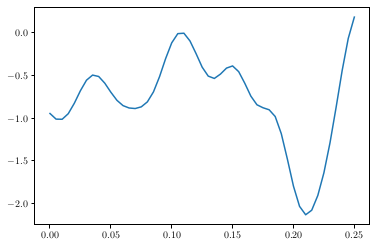

In [68]:
plt.plot(ftime, ftrue)

### True Noise

In [69]:
subkeyn = subkeys[-3]

# True noise variance
sign_true = 0.05

# Noise vector
noise_vec = sign_true * random.normal(subkeyn, (k + 1,))

### Output

In [70]:
# Padding and applying the FFT
xpad = np.append(xtest, np.zeros(n))
fpad = np.append(ftrue, np.zeros(k))

x_fft = np.fft.rfft(xpad)
f_fft = np.fft.rfft(fpad)

fftmul = x_fft * f_fft

ynonoise = np.fft.irfft(fftmul, n + k + 1)[:k + 1]

ytest = ynonoise + noise_vec
ytime = np.linspace(0.0, x_maxt, k + 1)

In [71]:
# Showing equals the raw convolution
yffttest = jnp.convolve(xtest, ftrue)[:k + 1] + noise_vec

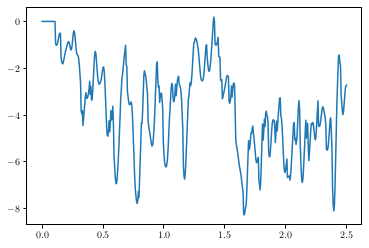

In [72]:
plt.plot(ytime, ynonoise)

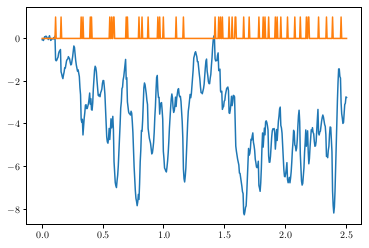

In [73]:
plt.plot(ytime, ytest)
plt.plot(xtime, xtest)

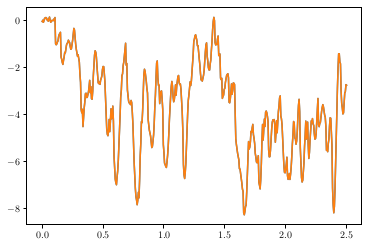

In [74]:
plt.plot(ytime, yffttest)
plt.plot(ytime, ytest)

## Variational Inference

### ELBO

#### Kl Divergence Term

In [75]:
@jit
def KL_Term(L_Matrix, V_Vector, M):
  return 0.5 * (- jnp.sum(jnp.log(jnp.diag(L_Matrix) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - M)

#### Log-Likelihood

In [76]:
@partial(jit, static_argnums = (2, 3, ))
def Log_Likelihood(F_Pad, Sigma_n, N, K, Y_Test, X_Fft):

  F_Fft = jnp.fft.rfft(F_Pad)

  Mean = jnp.fft.irfft(X_Fft * F_Fft, N + K + 1)[: K + 1]
  
  return - 0.5 * ((K + 1) * jnp.log(2 * jnp.pi * Sigma_n ** 2) + \
                  jnp.sum((Y_Test - Mean)**2)/(Sigma_n ** 2))

In [77]:
Vec_LL = jit(vmap(Log_Likelihood, in_axes = [0, None, None, None, None, None]),
             static_argnums = (2,3,))

In [78]:
test_mean = np.convolve(np.ones(10), np.arange(10))

In [79]:
print(jsc.stats.multivariate_normal.logpdf(ytest, ynonoise, sign_true**2 * np.eye(k + 1)))

796.2074311805818


In [80]:
print(Log_Likelihood(np.append(ftrue, np.zeros(k)), sign_true, n, k, ytest, x_fft))

796.2074397548586


#### Expected Log-Likelihood

In [81]:
# @partial(jit, static_argnums = range(6,10))
def Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, Number_F,
                  M, N, K, Y_Test, X_Fft, F_Time, Subkey):

  K_MM = Vec_SE(Z_Vector, Z_Vector, Sigma_f, Ell)
  K_MN = Vec_SE(Z_Vector, F_Time, Sigma_f, Ell)
  C = jnp.linalg.cholesky(K_MM + 1e-6 * jnp.eye(M)) 
  K_NN = Vec_SE(F_Time, F_Time, Sigma_f, Ell)
  
  B = jsc.linalg.solve_triangular(C, K_MN, lower = True)

  Mu_q = V_Vector @ B
  V_q = K_NN + B.T @ (L_Matrix @ L_Matrix.T - jnp.eye(M)) @ B

  Chol_Vq = jnp.linalg.cholesky(V_q + 1e-6 * jnp.eye(N + 1))

  F_Samples = Mu_q + random.normal(Subkey, (Number_F, N + 1)) @ Chol_Vq.T

  F_Samples = jnp.hstack((F_Samples, jnp.zeros((Number_F, K))))

  Likelihoods = Vec_LL(F_Samples, Sigma_n, N, K, Y_Test, X_Fft)

  return jnp.mean(Likelihoods)

In [82]:
test_number_f = 20000
test_m = int(11)
test_key = random.PRNGKey(0)
test_sigma_f = 1.0
test_ell_f = 0.01
test_sigma_n = 0.05
test_z_m = jnp.linspace(0.0, ftime[-1], test_m)
test_v_m = jnp.zeros(test_m)
test_l_mm = jnp.eye(test_m)

In [83]:
print(Expected_Term(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_mm, test_number_f, test_m, n, k, ytest, x_fft, ftime, test_key))

-2307834.3932912727


#### ELBO

In [84]:
@partial(jit, static_argnums = range(7, 11))
def Neg_ELBO(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, Number_F,
         M, N, K, Y_Test, X_Fft, F_Time, Subkey):

  Square_Frac = Z_Fractions ** 2.0
  Z_Vector = ((Square_Frac) / jnp.max(Square_Frac)) * F_Time[-1]

  Mask = jnp.tril(jnp.ones((M, M)), k = -1)

  D = jnp.diag(jnp.exp(L_Diag))

  L_Matrix = D + Mask * L_ODiag

  KL = KL_Term(L_Matrix, V_Vector, M)
  Exp = Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix,
                      Number_F, M, N, K, Y_Test, X_Fft, F_Time, Subkey)
  
  return (KL-Exp)/(K + 1)

In [85]:
test_number_f = 20000
test_m = 11
test_key = random.PRNGKey(0)
test_sigma_f = 2.0
test_ell_f = 0.7
test_sigma_n = 0.01
test_z_m = jnp.linspace(0.0, ftime[-1], test_m)
test_v_m1 = jnp.zeros(test_m)
test_v_m2 = 5.0 * jnp.ones(test_m)
test_l_diag = jnp.ones(test_m)
test_l_odiag = jnp.zeros((test_m, test_m))

In [86]:
print(Neg_ELBO(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m2, test_l_diag, test_l_odiag, test_number_f, test_m, n, k, ytest, x_fft, ftime, test_key))

26194385.891700596


In [87]:
Grad_Bound = jit(grad(Neg_ELBO, argnums = range(7)), static_argnums = range(7, 11))

### Optimiser

In [88]:
@jit
def MCalc(Grad, M, B1 = 0.9):
  return (1 - B1) * Grad + B1 * M

In [89]:
@jit
def MBias(M, Step, B1 = 0.9):
  return M / (1 - B1 ** (Step + 1))

In [90]:
@jit
def VCalc(Grad, V, B2 = 0.99):
  return (1 - B2) * jnp.square(Grad) + B2 * V

In [91]:
@jit
def VBias(V, Step, B2 = 0.99):
  return V / (1 - B2 ** (Step + 1))

In [92]:
@jit
def FinState(X, Mhat, Vhat, Step_Size = 1e-2, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [93]:
@jit
def Adam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(7))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(FinState, X, Mhat, Vhat)

  return X, M, V

In [94]:
@partial(jit, static_argnums = range(9,13))
def _Update(Iter, X, Mad, Vad,  Y_Test, X_Test, F_Time, Subkey, Key, Num_Coarse_Fs, M, N, K):

  Grads = Grad_Bound(*X, Num_Coarse_Fs, M, N, K, Y_Test, X_Test, F_Time, Subkey)
  X, Mad, Vad = Adam(Iter, X, Grads, Mad, Vad)
  Key, Subkey = random.split(Key)

  return (X, Mad, Vad, Y_Test, X_Test, F_Time, Subkey, Key)

In [95]:
@partial(jit, static_argnums = range(4, 8))
def AdamOpt(Init_Params, X_Fft, Y_Test, F_Time, M, N, K, Num_Coarse_Fs,              
                        Coarse_Sam = 1e-2, Mid_Sam = 1e-3, Fine_Sam = 1e-4,
                        Coarse_Schedule = [200], Mid_Schedule = [18500], Fine_Iters = [4000]):
  
  """
  Function implementing the Adam optimiser loop.
  """

  def Update(Iter, State):
    return _Update(Iter, *State, Num_Coarse_Fs, M, N, K)

  JUpdate = jit(Update)
  Mad = tree_map(jnp.zeros_like, Init_Params)
  Vad = tree_map(jnp.zeros_like, Init_Params)
  Key = random.PRNGKey(1)
  Key, Subkey = random.split(Key)
  Params = Init_Params

  Params = lax.fori_loop(1, Coarse_Schedule[0], JUpdate, (Params, Mad, Vad, Y_Test, X_Fft,
                                           F_Time, Subkey, Key))

  return Params[0]

In [96]:
key = random.PRNGKey(4)

# Initialising the parameters

# Generative parameters
isigma_f = 2.0
iell = 0.03
isigma_n = 0.5

# Varitiational parameters
num_ind = 30
iz_vector = jnp.sqrt(jnp.linspace(0.00,1.0, num_ind))
key, *subkeys = random.split(key, 4)
iv_vector = jnp.zeros(num_ind) + 0.01 * random.normal(subkeys[-3], (num_ind,))
il_diag = jnp.zeros(num_ind) + 0.01 * random.normal(subkeys[-2], (num_ind,))
il_odiag = jnp.tril(jnp.zeros((num_ind, num_ind)) + 0.1 * random.normal(subkeys[-1], (num_ind, num_ind)), -1)
# il_odiag = jnp.zeros(int((num_ind ** 2 - num_ind) / 2)) + \
#             0.1 * random.normal(subkeys[-1], (int((num_ind ** 2 - num_ind) / 2),))
num_f = 20000

# Random number generator
opt_key = random.PRNGKey(1)
opt_key, opt_subkey = random.split(opt_key)

params = (isigma_f, iell, isigma_n, iz_vector, iv_vector, il_diag, il_odiag)
consparams = (num_ind, n, k, ytest, x_fft, ftime)

In [97]:
num_iter = 1000

In [ ]:
%%timeit
# Getting num_iter ELBOs using a Python for-loop
for i in range(num_iter):
  test_elbo = Neg_ELBO(isigma_f * i, iell, isigma_n * i, iz_vector, iv_vector,
                   il_diag, il_odiag, num_f, num_ind, n, k, ytest, x_fft, ftime,
                   opt_subkey)

12.2 s ± 40 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [81]:
%%timeit
# Getting num_iter ELBOs using a Python for-loop
for i in range(num_iter):
  test_elbo = Neg_ELBO(isigma_f * i, iell, isigma_n * i, iz_vector, iv_vector,
                   il_diag, il_odiag, num_f, num_ind, n, k, ytest, x_fft, ftime,
                   opt_subkey)

12.1 s ± 8.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [100]:
%%timeit
# Getting num_iter gradients using a Python for-loop
for i in range(num_iter):
  test_grad = Grad_Bound(isigma_f * i, iell, isigma_n * i, iz_vector, iv_vector,
                   il_diag, il_odiag, num_f, num_ind, n, k, ytest, x_fft, ftime,
                   opt_subkey)

26.9 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
fparams = AdamOpt(params, x_fft, ytest, ftime, num_ind, n, k, num_f, Coarse_Schedule = [num_iter])

In [51]:
%%timeit
# Implementing num_iter Adam iterations, using JAX's primitives
fparams = AdamOpt(params, x_fft, ytest, ftime, num_ind, n, k, num_f, Coarse_Schedule = [num_iter])

27 s ± 53.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [84]:
%%timeit
# Implementing num_iter Adam iterations, using JAX's primitives
fparams = AdamOpt(params, x_fft, ytest, ftime, num_ind, n, k, num_f, Coarse_Schedule = [num_iter])

27 s ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
print(Neg_ELBO(*fparams, num_f, *consparams, opt_subkey))

0.4829889045418303


In [86]:
fsigma_f, fell, fsigma_n, fz_fracs, fv_vector, fl_diag, fl_odiag = fparams

In [87]:
print(fsigma_f)

1.427244213818465


In [88]:
print(fell)

-0.05567799773425486


In [89]:
print(fsigma_n)

0.3650147647304206


In [90]:
fsquares = fz_fracs ** 2
print(ftime[-1])
fz_vector = ((fsquares) / jnp.max(fsquares)) * ftime[-1]
print(fz_vector)

0.25
[0.         0.0118221  0.00102743 0.02347005 0.04089818 0.05680412
 0.07566664 0.03975251 0.08172461 0.09110777 0.10028853 0.11610938
 0.08867736 0.07752808 0.12442849 0.13108673 0.13592321 0.14009031
 0.14429585 0.14804573 0.14759994 0.14310927 0.12677461 0.14637557
 0.12638576 0.14696994 0.25       0.19730105 0.13325963 0.18405721]


In [91]:
print(fv_vector)

[-0.66507483  0.22289518  0.46405108 -0.34542485 -0.03179514  0.27220032
  0.09421544 -0.18972423 -0.09383126 -0.19231998 -0.26433689 -0.5119844
  0.01045332 -0.17327549 -0.66622052 -0.58354693 -0.60415464 -0.60004075
 -0.67134259 -0.53006162 -0.20501894  0.20447346 -0.22083817 -0.12633978
 -0.17151042 -0.06511321  1.93230084 -3.93799621 -0.48481737  2.1894462 ]


In [92]:
d = np.diag(np.exp(fl_diag))

fl_matrix = d + np.zeros(num_ind)
fl_matrix[np.tril_indices(num_ind, -1)] = fl_odiag
print(fl_matrix)

[[ 6.90276472e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.40183357e-01  1.16756951e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.3

## Variational Predictions

In [93]:
fpred_points = ftime.copy()

In [94]:
ikmm = Vec_SE(iz_vector, iz_vector, isigma_f, iell)
icpred = np.linalg.cholesky(ikmm + 1e-6 * np.eye(num_ind))
ikzast = Vec_SE(iz_vector, fpred_points, isigma_f, iell)
ibast = sc.linalg.solve_triangular(icpred, ikzast, lower = True)
icov_pred = Vec_SE(fpred_points, fpred_points, isigma_f, iell) + \
           ibast.T @ (fl_matrix @ fl_matrix.T - np.eye(num_ind)) @ ibast
imean_pred = fv_vector @ ibast
print(icov_pred)

[[ 0.01906026  0.01879736  0.01803023 ... -0.10319094 -0.11056912
  -0.11671202]
 [ 0.01879736  0.12812018  0.23096217 ... -0.10176764 -0.10904405
  -0.11510222]
 [ 0.01803023  0.23096217  0.4376986  ... -0.09761446 -0.1045939
  -0.11040483]
 ...
 [-0.10319094 -0.10176764 -0.09761446 ...  2.64959754  2.45931214
   2.19133862]
 [-0.11056912 -0.10904405 -0.1045939  ...  2.45931214  2.34485418
   2.15528959]
 [-0.11671202 -0.11510222 -0.11040483 ...  2.19133862  2.15528959
   2.05418513]]


In [95]:
kmm = Vec_SE(fz_vector, fz_vector, fsigma_f, fell)
cpred = np.linalg.cholesky(kmm + 1e-6 * np.eye(num_ind))
kzast = Vec_SE(fz_vector, fpred_points, fsigma_f, fell)
bast = sc.linalg.solve_triangular(cpred, kzast, lower = True)
cov_pred = Vec_SE(fpred_points, fpred_points, fsigma_f, fell) + \
           bast.T @ (fl_matrix @ fl_matrix.T - np.eye(num_ind)) @ bast
mean_pred = fv_vector @ bast
print(cov_pred)

[[ 9.70258308e-03  6.16399631e-03  3.27597907e-03 ... -2.01664716e-04
  -3.06693694e-04 -5.35887596e-04]
 [ 6.16399631e-03  4.27873869e-03  2.68445723e-03 ... -1.86680600e-04
  -2.01852313e-04 -2.65051010e-04]
 [ 3.27597907e-03  2.68445723e-03  2.11985476e-03 ... -1.78108268e-04
  -1.35062675e-04 -8.16264993e-05]
 ...
 [-2.01664716e-04 -1.86680600e-04 -1.78108268e-04 ...  1.53717716e-03
   1.65543082e-03  1.65699242e-03]
 [-3.06693694e-04 -2.01852313e-04 -1.35062675e-04 ...  1.65543082e-03
   2.28409416e-03  2.97873596e-03]
 [-5.35887596e-04 -2.65051010e-04 -8.16264993e-05 ...  1.65699242e-03
   2.97873596e-03  4.66720605e-03]]


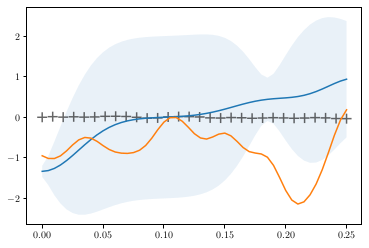

In [96]:
plt.plot(fpred_points, imean_pred)
plt.plot(ftime, ftrue)
is2 = np.sqrt(np.diag(icov_pred))
ifill = (imean_pred - is2, imean_pred + is2)
plt.fill_between(fpred_points, *ifill, alpha = 0.1)
isquares = iz_vector ** 2
izvec = ((isquares) / jnp.max(isquares)) * ftime[-1]
plt.scatter(izvec, iv_vector @ icpred.T, s = 100, marker = '+', c='k', alpha = 0.6)

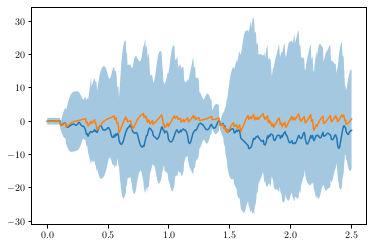

In [97]:
plt.plot(ytime, ytest)
plt.plot(ytime, np.convolve(xtest, imean_pred)[: k + 1])
plt.fill_between(ytime, np.convolve(xtest, imean_pred - 2*is2)[: k + 1] - 2* isigma_n,
                    np.convolve(xtest, imean_pred + 2*is2)[: k + 1] + 2* isigma_n, alpha = 0.4)

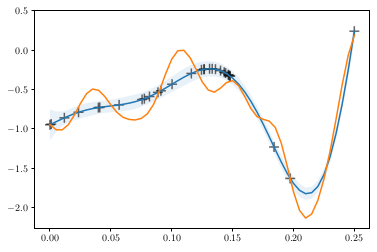

In [98]:
plt.plot(fpred_points, mean_pred)
plt.plot(ftime, ftrue)
s2 = np.sqrt(np.diag(cov_pred))
fill = (mean_pred - 2*s2, mean_pred + 2*s2)
plt.fill_between(fpred_points, *fill, alpha = 0.1)
plt.scatter(fz_vector, fv_vector @ cpred.T , s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([0.0, 0.25])

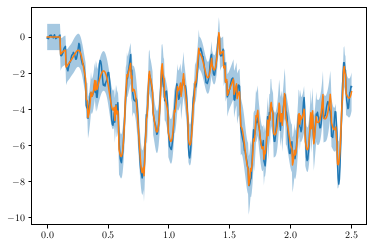

In [99]:
plt.plot(ytime, ytest)
plt.plot(ytime, np.convolve(xtest, mean_pred)[: k + 1])
plt.fill_between(ytime, np.convolve(xtest, mean_pred - 2*s2)[: k + 1] - 2* fsigma_n,
                    np.convolve(xtest, mean_pred + 2*s2)[: k + 1] + 2* fsigma_n, alpha = 0.4)